In [1]:
import os
from time import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from sklearn.metrics import r2_score, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
from tqdm import tqdm

In [2]:
# Implement from scratch the following normalization schemes. They should
# be implemented as a sub-class of torch.nn.Module.

# (a) Batch Normalization (BN) [3]
# (b) Instance Normalization (IN) [7]
# (c) Batch-Instance Normalization (BIN) [4]
# (d) Layer Normalization (LN) [1]
# (e) Group Normalization (GN) [8]

import torch
import torch.nn as nn

class NoNormalise(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(NoNormalise, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))

    def forward(self, x):
        return x

class BatchNormalise(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(BatchNormalise, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))
        self.running_mean = 0
        self.running_var = 0
        # shape = (1, num_features, 1, 1)
        
    def forward(self, x):
        if self.training:
            mean = x.mean(dim=[0, 2, 3])
            variance = x.var(dim=[0, 2, 3])
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * variance
        else:
            mean = self.running_mean
            variance = self.running_var
        x = (x - mean.view(1, -1, 1, 1)) / (variance.view(1, -1, 1, 1) + self.eps).sqrt()
        x = self.gamma.view(1, -1, 1, 1) * x + self.beta.view(1, -1, 1, 1)
        return x
    

class InstanceNormalise(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(InstanceNormalise, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))
        shape = (1, num_features, 1, 1)

    def forward(self, x):
        if self.training:
            mean = x.mean(dim=[2, 3], keepdim=True)
            variance = x.var(dim=[2, 3], keepdim=True)
        else:
            mean = x.mean(dim=[2, 3], keepdim=True)
            variance = x.var(dim=[2, 3], keepdim=True)
        x = (x - mean) / (variance + self.eps).sqrt()
        x = self.gamma.view(1, -1, 1, 1) * x + self.beta.view(1, -1, 1, 1)
        return x

  

class BatchInstanceNormalise(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(BatchInstanceNormalise, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))
        self.running_mean = 0
        self.running_var = 0
        shape = (1, num_features, 1, 1)

    def forward(self, x):
        if self.training:
            mean = x.mean(dim=[0, 2, 3])
            variance = x.var(dim=[0, 2, 3])
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * variance
        else:
            mean = self.running_mean
            variance = self.running_var
        x = (x - mean.view(1, -1, 1, 1)) / (variance.view(1, -1, 1, 1) + self.eps).sqrt()
        x = self.gamma.view(1, -1, 1, 1) * x + self.beta.view(1, -1, 1, 1)
        mean = x.mean(dim=[2, 3], keepdim=True)
        variance = x.var(dim=[2, 3], keepdim=True)
        x = (x - mean) / (variance + self.eps).sqrt()
        x = self.gamma.view(1, -1, 1, 1) * x + self.beta.view(1, -1, 1, 1)
        return x

    

class LayerNormalise(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(LayerNormalise, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))
        shape = (1, num_features, 1, 1)

    def forward(self, x):
        if self.training:
            mean = x.mean(dim=[1, 2, 3], keepdim=True)
            variance = x.var(dim=[1, 2, 3], keepdim=True)
        else:
            mean = x.mean(dim=[1, 2, 3], keepdim=True)
            variance = x.var(dim=[1, 2, 3], keepdim=True)
        x = (x - mean) / (variance + self.eps).sqrt()
        x = self.gamma.view(1, -1, 1, 1) * x + self.beta.view(1, -1, 1, 1)
        return x
    

class GroupNormalise(nn.Module):
    def __init__(self, num_features, num_groups=4, eps=1e-5, momentum=0.1):
        super(GroupNormalise, self).__init__()
        self.num_features = num_features
        self.num_groups = num_groups
        self.eps = eps
        self.momentum = momentum
        self.gamma = nn.Parameter(torch.ones(1, num_features, 1, 1))
        self.beta = nn.Parameter(torch.zeros(1, num_features, 1, 1))

    def forward(self, x):
        N, C, H, W = x.size()
        x = x.view(N, self.num_groups, int(C / self.num_groups), H, W)
        mean = x.mean(dim=[1, 2, 3], keepdim=True)
        variance = x.var(dim=[1, 2, 3], keepdim=True)
        x = (x - mean) / (variance + self.eps).sqrt()
        x = x.view(N, C, H, W)
        x = self.gamma * x + self.beta
        return x

In [3]:
def norms(dimension, norm_type):
    if norm_type == 'none':
        return NoNormalise(dimension)
    elif norm_type == 'batch':
        return BatchNormalise(dimension)
    elif norm_type == 'instance':
        return InstanceNormalise(dimension)
    elif norm_type == 'batchinstance':
        return BatchInstanceNormalise(dimension)
    elif norm_type == 'layer':
        return LayerNormalise(dimension)
    elif norm_type == 'group':
        return GroupNormalise(dimension)
    else:
        raise ValueError('Invalid norm type')
    

class resd_block(nn.Module):
    def __init__(self, in_chs, out_chs, downsampling=None, stride=1, norm_type='none'):
        super(resd_block, self).__init__()
        self.conv1 = nn.Conv2d(in_chs, out_chs, kernel_size=3, stride=stride, padding=1)
        self.bn1 = norms(out_chs, norm_type)
        self.conv2 = nn.Conv2d(out_chs, out_chs, kernel_size=3, stride=1, padding=1)
        self.bn2 = norms(out_chs, norm_type)
        self.downsampling = downsampling
        self.relu = nn.ReLU()
        self.out_chs = out_chs

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsampling is not None:
            identity = self.downsampling(x)
        out += identity
        out = self.relu(out)
        return out
    

class resnet(nn.Module): # n layers of blocks, r classes
    def __init__(self, resd_block, layers, img_chs, r, norm_type):
        super(resnet, self).__init__()
        self.in_chs = 16
        self.conv1 = nn.Conv2d(img_chs, 16, kernel_size=3, stride=1, padding=1)
        self.bn = norms(16, norm_type)
        self.relu = nn.ReLU()
        self.layer1 = self.add_layer(resd_block, 16, layers[0], 1, norm_type)
        self.layer2 = self.add_layer(resd_block, 32, layers[1], 2, norm_type)
        self.layer3 = self.add_layer(resd_block, 64, layers[2], 2, norm_type)
        self.avg_pool = nn.AvgPool2d(kernel_size=64)
        self.fc = nn.Linear(64, r)

    def add_layer(self, resd_block, out_chs, n, stride, norm_type):
        downsampling = None
        if (stride != 1) or (self.in_chs != out_chs):
            downsampling = nn.Sequential(nn.Conv2d(self.in_chs, out_chs, kernel_size=3, stride=stride, padding=1), norms(out_chs, norm_type))
        layers = []
        layers.append(resd_block(self.in_chs, out_chs, downsampling, stride, norm_type))
        self.in_chs = out_chs

        for i in range(1, n):
            layers.append(resd_block(self.in_chs, out_chs, norm_type=norm_type))
            
        return nn.Sequential(*layers)
    

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
    

def final_resnet(img_chs, r, n, norm_type):
    return resnet(resd_block, [n, n, n], img_chs, r, norm_type)

In [4]:
# The hyperparameters

n = 2
r = 25
batch_size = 32
# learning_rate = 0.0001
num_epochs = 50 
num_workers = 4
norm_type = 'instance'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


print("Device: ", device)

Device:  cuda:0


Train Data:  29417
Validation Data:  8413
------------------------Training Started------------------------


100%|██████████| 263/263 [00:20<00:00, 12.77it/s]


Epoch:  0 Train Loss:  0.09362816900571068 Train Accuracy:  14.1720773702281 Train F1 Macro:  0.11007558446815853 Train F1 Micro:  0.141720773702281
Epoch:  0 Validation Loss:  0.08663608069143836 Validation Accuracy:  21.74016403185546 Validation F1 Macro:  0.18030072103152484 Validation F1 Micro:  0.2174016403185546
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.81it/s]


Epoch:  1 Train Loss:  0.08106805339126855 Train Accuracy:  26.04276438793895 Train F1 Macro:  0.2277448150106045 Train F1 Micro:  0.2604276438793895
Epoch:  1 Validation Loss:  0.07642118145534489 Validation Accuracy:  30.702484250564606 Validation F1 Macro:  0.2586476112107372 Validation F1 Micro:  0.30702484250564605
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.75it/s]


Epoch:  2 Train Loss:  0.07262742966357777 Train Accuracy:  33.77638780297107 Train F1 Macro:  0.3049942041054624 Train F1 Micro:  0.3377638780297107
Epoch:  2 Validation Loss:  0.06831464518920344 Validation Accuracy:  38.01259954831808 Validation F1 Macro:  0.34308778635294473 Validation F1 Micro:  0.38012599548318077
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.80it/s]


Epoch:  3 Train Loss:  0.0654570157950102 Train Accuracy:  40.35421694938301 Train F1 Macro:  0.38027555662160833 Train F1 Micro:  0.4035421694938301
Epoch:  3 Validation Loss:  0.06165205215877831 Validation Accuracy:  44.383691905384524 Validation F1 Macro:  0.4260669755185957 Validation F1 Micro:  0.44383691905384526
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.71it/s]


Epoch:  4 Train Loss:  0.05933387837038936 Train Accuracy:  45.20515348268008 Train F1 Macro:  0.4330381222475081 Train F1 Micro:  0.4520515348268008
Epoch:  4 Validation Loss:  0.056939907643878046 Validation Accuracy:  48.496374658266966 Validation F1 Macro:  0.47030795496798755 Validation F1 Micro:  0.48496374658266966
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.75it/s]


Epoch:  5 Train Loss:  0.05468656261225716 Train Accuracy:  49.13145460108101 Train F1 Macro:  0.47352791256778237 Train F1 Micro:  0.4913145460108101
Epoch:  5 Validation Loss:  0.05169822681422014 Validation Accuracy:  51.62248900511114 Validation F1 Macro:  0.4877199833722427 Validation F1 Micro:  0.5162248900511114
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.75it/s]


Epoch:  6 Train Loss:  0.05080052506458866 Train Accuracy:  51.786382023999735 Train F1 Macro:  0.5018502360421839 Train F1 Micro:  0.5178638202399973
Epoch:  6 Validation Loss:  0.04935351457293161 Validation Accuracy:  52.549625579460354 Validation F1 Macro:  0.5118258934369028 Validation F1 Micro:  0.5254962557946036
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.79it/s]


Epoch:  7 Train Loss:  0.047773484714934825 Train Accuracy:  54.77445014787368 Train F1 Macro:  0.5358286184937034 Train F1 Micro:  0.5477445014787368
Epoch:  7 Validation Loss:  0.04568071777268254 Validation Accuracy:  56.86437656008558 Validation F1 Macro:  0.5537950612951622 Validation F1 Micro:  0.5686437656008558
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.74it/s]


Epoch:  8 Train Loss:  0.04546769124166352 Train Accuracy:  56.691708875820105 Train F1 Macro:  0.5569739100302101 Train F1 Micro:  0.566917088758201
Epoch:  8 Validation Loss:  0.045234303181539544 Validation Accuracy:  57.18530845120646 Validation F1 Macro:  0.5554801186440348 Validation F1 Micro:  0.5718530845120646
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.80it/s]


Epoch:  9 Train Loss:  0.043441954905817315 Train Accuracy:  58.323418431519194 Train F1 Macro:  0.5753051890849135 Train F1 Micro:  0.5832341843151919
Epoch:  9 Validation Loss:  0.04255313521104294 Validation Accuracy:  59.32485439201236 Validation F1 Macro:  0.5782580006244725 Validation F1 Micro:  0.5932485439201236
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.76it/s]


Epoch:  10 Train Loss:  0.041704870909113054 Train Accuracy:  60.01971649046469 Train F1 Macro:  0.5938993774934763 Train F1 Micro:  0.6001971649046469
Epoch:  10 Validation Loss:  0.0406056517449738 Validation Accuracy:  62.248900511113746 Validation F1 Macro:  0.6227221563776196 Validation F1 Micro:  0.6224890051111375
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.76it/s]


Epoch:  11 Train Loss:  0.040189613286345904 Train Accuracy:  61.348879899377906 Train F1 Macro:  0.6089019528072952 Train F1 Micro:  0.6134887989937791
Epoch:  11 Validation Loss:  0.038794921235296854 Validation Accuracy:  62.878877927017705 Validation F1 Macro:  0.6175603609688494 Validation F1 Micro:  0.6287887792701771
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.72it/s]


Epoch:  12 Train Loss:  0.03883284344551423 Train Accuracy:  62.78002515552231 Train F1 Macro:  0.6234418174671071 Train F1 Micro:  0.6278002515552231
Epoch:  12 Validation Loss:  0.03721048251550716 Validation Accuracy:  65.06596933317485 Validation F1 Macro:  0.6489762856033252 Validation F1 Micro:  0.6506596933317484
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.77it/s]


Epoch:  13 Train Loss:  0.03776284923332044 Train Accuracy:  63.64687085698746 Train F1 Macro:  0.6333696847426252 Train F1 Micro:  0.6364687085698746
Epoch:  13 Validation Loss:  0.0370843227597149 Validation Accuracy:  64.76881017472958 Validation F1 Macro:  0.6488512646559618 Validation F1 Micro:  0.6476881017472959
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.67it/s]


Epoch:  14 Train Loss:  0.036510309633823054 Train Accuracy:  65.08141550803957 Train F1 Macro:  0.6480318099055844 Train F1 Micro:  0.6508141550803956
Epoch:  14 Validation Loss:  0.03533529213481435 Validation Accuracy:  66.8251515511708 Validation F1 Macro:  0.6689407400999196 Validation F1 Micro:  0.668251515511708
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.74it/s]


Epoch:  15 Train Loss:  0.035578890028673225 Train Accuracy:  65.95166060441241 Train F1 Macro:  0.6570187665476463 Train F1 Micro:  0.6595166060441241
Epoch:  15 Validation Loss:  0.03788655263574458 Validation Accuracy:  62.6411506002615 Validation F1 Macro:  0.6244241000335249 Validation F1 Micro:  0.626411506002615
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.81it/s]


Epoch:  16 Train Loss:  0.034719252134928 Train Accuracy:  66.62474079613828 Train F1 Macro:  0.6645973360724446 Train F1 Micro:  0.6662474079613828
Epoch:  16 Validation Loss:  0.03392509435779853 Validation Accuracy:  68.5011292048021 Validation F1 Macro:  0.6856870941957527 Validation F1 Micro:  0.6850112920480209
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.64it/s]


Epoch:  17 Train Loss:  0.03374822447235686 Train Accuracy:  67.91651086106673 Train F1 Macro:  0.6778652020574404 Train F1 Micro:  0.6791651086106673
Epoch:  17 Validation Loss:  0.03318818921703058 Validation Accuracy:  68.25151551170808 Validation F1 Macro:  0.6783867238279443 Validation F1 Micro:  0.6825151551170807
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.75it/s]


Epoch:  18 Train Loss:  0.033042880948777956 Train Accuracy:  68.4298194921304 Train F1 Macro:  0.683246063944056 Train F1 Micro:  0.6842981949213041
Epoch:  18 Validation Loss:  0.03256705354265519 Validation Accuracy:  69.071674789017 Validation F1 Macro:  0.692427186021342 Validation F1 Micro:  0.69071674789017
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.77it/s]


Epoch:  19 Train Loss:  0.032227509172791775 Train Accuracy:  69.22527790053371 Train F1 Macro:  0.6917982514799421 Train F1 Micro:  0.6922527790053371
Epoch:  19 Validation Loss:  0.032186611770386224 Validation Accuracy:  69.93937953167718 Validation F1 Macro:  0.7008670971522863 Validation F1 Micro:  0.6993937953167717
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.76it/s]


Epoch:  20 Train Loss:  0.031494489493617904 Train Accuracy:  69.84056837882858 Train F1 Macro:  0.6978682172684892 Train F1 Micro:  0.6984056837882857
Epoch:  20 Validation Loss:  0.030971774521231666 Validation Accuracy:  70.64067514560799 Validation F1 Macro:  0.7070517469662425 Validation F1 Micro:  0.7064067514560799
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.71it/s]


Epoch:  21 Train Loss:  0.03088861652002031 Train Accuracy:  70.4422612774926 Train F1 Macro:  0.704068724090725 Train F1 Micro:  0.704422612774926
Epoch:  21 Validation Loss:  0.03018059997131804 Validation Accuracy:  71.94817544276715 Validation F1 Macro:  0.7197524470377344 Validation F1 Micro:  0.7194817544276715
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.78it/s]


Epoch:  22 Train Loss:  0.030304100040381716 Train Accuracy:  71.19692694700343 Train F1 Macro:  0.7117576973783405 Train F1 Micro:  0.7119692694700344
Epoch:  22 Validation Loss:  0.029302106247204147 Validation Accuracy:  73.05360751218353 Validation F1 Macro:  0.7320719079841013 Validation F1 Micro:  0.7305360751218353
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.79it/s]


Epoch:  23 Train Loss:  0.02973556269028495 Train Accuracy:  71.80881803039058 Train F1 Macro:  0.7181214236908978 Train F1 Micro:  0.718088180303906
Epoch:  23 Validation Loss:  0.03032199017155345 Validation Accuracy:  70.7833115416617 Validation F1 Macro:  0.7095336805690856 Validation F1 Micro:  0.707833115416617
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.78it/s]


Epoch:  24 Train Loss:  0.029185631924816366 Train Accuracy:  72.09776659754563 Train F1 Macro:  0.7210059894793858 Train F1 Micro:  0.7209776659754563
Epoch:  24 Validation Loss:  0.028544019980332406 Validation Accuracy:  73.62415309639843 Validation F1 Macro:  0.7399575187977951 Validation F1 Micro:  0.7362415309639841
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.73it/s]


Epoch:  25 Train Loss:  0.028542665720682973 Train Accuracy:  73.01560322262637 Train F1 Macro:  0.7303043811648222 Train F1 Micro:  0.7301560322262637
Epoch:  25 Validation Loss:  0.027525649907599443 Validation Accuracy:  74.39676690835611 Validation F1 Macro:  0.7436006871069215 Validation F1 Micro:  0.7439676690835612
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.78it/s]


Epoch:  26 Train Loss:  0.028217018931160916 Train Accuracy:  73.41333242682802 Train F1 Macro:  0.7341465851677398 Train F1 Micro:  0.7341333242682804
Epoch:  26 Validation Loss:  0.02721498657580747 Validation Accuracy:  74.9435397598954 Validation F1 Macro:  0.7498597216184986 Validation F1 Micro:  0.7494353975989541
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.74it/s]


Epoch:  27 Train Loss:  0.02771140038653072 Train Accuracy:  73.72267736342931 Train F1 Macro:  0.7374809080829641 Train F1 Micro:  0.7372267736342931
Epoch:  27 Validation Loss:  0.027138295688481643 Validation Accuracy:  75.05051705693569 Validation F1 Macro:  0.7514728254230719 Validation F1 Micro:  0.750505170569357
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.76it/s]


Epoch:  28 Train Loss:  0.02737916550273359 Train Accuracy:  73.90624468844545 Train F1 Macro:  0.7395312243240914 Train F1 Micro:  0.7390624468844545
Epoch:  28 Validation Loss:  0.026419685963347764 Validation Accuracy:  75.16938072031381 Validation F1 Macro:  0.7503917460147963 Validation F1 Micro:  0.751693807203138
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.82it/s]


Epoch:  29 Train Loss:  0.026847141135998003 Train Accuracy:  74.51813577183262 Train F1 Macro:  0.7455353086683121 Train F1 Micro:  0.7451813577183262
Epoch:  29 Validation Loss:  0.02635603323959644 Validation Accuracy:  75.10994888862474 Validation F1 Macro:  0.7510005631960123 Validation F1 Micro:  0.7510994888862474
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.73it/s]


Epoch:  30 Train Loss:  0.02655143904873195 Train Accuracy:  74.74589523064894 Train F1 Macro:  0.7477275627783594 Train F1 Micro:  0.7474589523064895
Epoch:  30 Validation Loss:  0.026251935540326184 Validation Accuracy:  75.52597171044812 Validation F1 Macro:  0.7566518753467009 Validation F1 Micro:  0.7552597171044811
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.72it/s]


Epoch:  31 Train Loss:  0.02608193448667244 Train Accuracy:  75.38158207839004 Train F1 Macro:  0.7542793532121741 Train F1 Micro:  0.7538158207839004
Epoch:  31 Validation Loss:  0.02663209003970978 Validation Accuracy:  74.46808510638297 Validation F1 Macro:  0.7474608804940857 Validation F1 Micro:  0.7446808510638298
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.80it/s]


Epoch:  32 Train Loss:  0.02580834241282483 Train Accuracy:  75.68412822517591 Train F1 Macro:  0.7573287243901901 Train F1 Micro:  0.7568412822517592
Epoch:  32 Validation Loss:  0.02570784210974547 Validation Accuracy:  75.93010816593367 Validation F1 Macro:  0.7582730872083541 Validation F1 Micro:  0.7593010816593367
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.75it/s]


Epoch:  33 Train Loss:  0.025501932998596214 Train Accuracy:  75.83030220620729 Train F1 Macro:  0.7585701428937209 Train F1 Micro:  0.7583030220620729
Epoch:  33 Validation Loss:  0.0256005863247389 Validation Accuracy:  76.22726732437893 Validation F1 Macro:  0.7656175697519623 Validation F1 Micro:  0.7622726732437893
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.76it/s]


Epoch:  34 Train Loss:  0.025051964318302068 Train Accuracy:  76.39800115579428 Train F1 Macro:  0.7644299850702231 Train F1 Micro:  0.7639800115579427
Epoch:  34 Validation Loss:  0.02454805830142649 Validation Accuracy:  77.34458576013313 Validation F1 Macro:  0.7746502119822316 Validation F1 Micro:  0.7734458576013311
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.72it/s]


Epoch:  35 Train Loss:  0.024861875899073002 Train Accuracy:  76.54417513682564 Train F1 Macro:  0.7659859281940088 Train F1 Micro:  0.7654417513682564
Epoch:  35 Validation Loss:  0.024551153747112704 Validation Accuracy:  77.03554023535006 Validation F1 Macro:  0.7736672295068368 Validation F1 Micro:  0.7703554023535005
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.75it/s]


Epoch:  36 Train Loss:  0.024528994448638753 Train Accuracy:  76.88751402250399 Train F1 Macro:  0.76954018749944 Train F1 Micro:  0.7688751402250399
Epoch:  36 Validation Loss:  0.024249524041934145 Validation Accuracy:  77.91513134434803 Validation F1 Macro:  0.7816525894691446 Validation F1 Micro:  0.7791513134434803
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.78it/s]


Epoch:  37 Train Loss:  0.024291940891277085 Train Accuracy:  77.1492674303974 Train F1 Macro:  0.772129908741121 Train F1 Micro:  0.7714926743039738
Epoch:  37 Validation Loss:  0.023870300002990348 Validation Accuracy:  78.29549506715797 Validation F1 Macro:  0.7834644356960019 Validation F1 Micro:  0.7829549506715797
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.65it/s]


Epoch:  38 Train Loss:  0.024002511237015085 Train Accuracy:  77.52999966006051 Train F1 Macro:  0.7758915776151101 Train F1 Micro:  0.775299996600605
Epoch:  38 Validation Loss:  0.023794075541227477 Validation Accuracy:  78.04588137406395 Validation F1 Macro:  0.7804682303517688 Validation F1 Micro:  0.7804588137406394
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.77it/s]


Epoch:  39 Train Loss:  0.023795652086407257 Train Accuracy:  77.67277424618419 Train F1 Macro:  0.7774415138794373 Train F1 Micro:  0.7767277424618418
Epoch:  39 Validation Loss:  0.023388034488634295 Validation Accuracy:  78.7828360870082 Validation F1 Macro:  0.7899291076234332 Validation F1 Micro:  0.787828360870082
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.74it/s]


Epoch:  40 Train Loss:  0.023572778540294305 Train Accuracy:  78.0467076860319 Train F1 Macro:  0.7812032617663565 Train F1 Micro:  0.7804670768603189
Epoch:  40 Validation Loss:  0.023269675785411514 Validation Accuracy:  78.48567692856294 Validation F1 Macro:  0.7849680746283663 Validation F1 Micro:  0.7848567692856294
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.67it/s]


Epoch:  41 Train Loss:  0.02337606222011881 Train Accuracy:  78.27446714484822 Train F1 Macro:  0.7833946705738749 Train F1 Micro:  0.7827446714484821
Epoch:  41 Validation Loss:  0.02322750488949505 Validation Accuracy:  78.72340425531915 Validation F1 Macro:  0.787420658028268 Validation F1 Micro:  0.7872340425531915
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.77it/s]


Epoch:  42 Train Loss:  0.02321667068227571 Train Accuracy:  78.47163204949518 Train F1 Macro:  0.7853162043175912 Train F1 Micro:  0.7847163204949518
Epoch:  42 Validation Loss:  0.023197862887209285 Validation Accuracy:  78.56888149292762 Validation F1 Macro:  0.7866286025139599 Validation F1 Micro:  0.7856888149292761
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.79it/s]


Epoch:  43 Train Loss:  0.023026526060387065 Train Accuracy:  78.56681510691097 Train F1 Macro:  0.7863816640634669 Train F1 Micro:  0.7856681510691097
Epoch:  43 Validation Loss:  0.022817700265293582 Validation Accuracy:  79.06810887911566 Validation F1 Macro:  0.7912980931233762 Validation F1 Micro:  0.7906810887911565
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.68it/s]


Epoch:  44 Train Loss:  0.0229028258180782 Train Accuracy:  78.66879695414217 Train F1 Macro:  0.7874017090164017 Train F1 Micro:  0.7866879695414215
Epoch:  44 Validation Loss:  0.022898018123681856 Validation Accuracy:  79.3296089385475 Validation F1 Macro:  0.7956476337681276 Validation F1 Micro:  0.7932960893854749
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.76it/s]


Epoch:  45 Train Loss:  0.022759404169304324 Train Accuracy:  78.87276064860454 Train F1 Macro:  0.7895592141016837 Train F1 Micro:  0.7887276064860455
Epoch:  45 Validation Loss:  0.02244362319024468 Validation Accuracy:  79.674313562344 Validation F1 Macro:  0.7976527970177879 Validation F1 Micro:  0.7967431356234399
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.79it/s]


Epoch:  46 Train Loss:  0.02265504135692266 Train Accuracy:  79.03593160417446 Train F1 Macro:  0.7910715633900982 Train F1 Micro:  0.7903593160417446
Epoch:  46 Validation Loss:  0.022425638461961737 Validation Accuracy:  79.42469986924998 Validation F1 Macro:  0.7943500668648372 Validation F1 Micro:  0.7942469986924997
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.75it/s]


Epoch:  47 Train Loss:  0.022563425105315976 Train Accuracy:  79.13111466159025 Train F1 Macro:  0.7920874278752842 Train F1 Micro:  0.7913111466159024
Epoch:  47 Validation Loss:  0.022327438481732128 Validation Accuracy:  79.54356353262808 Validation F1 Macro:  0.7962469772576724 Validation F1 Micro:  0.7954356353262809
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.71it/s]


Epoch:  48 Train Loss:  0.022436161806270803 Train Accuracy:  79.38946867457592 Train F1 Macro:  0.7946110385587333 Train F1 Micro:  0.7938946867457591
Epoch:  48 Validation Loss:  0.022314815400426232 Validation Accuracy:  79.62676809699275 Validation F1 Macro:  0.7962919744162239 Validation F1 Micro:  0.7962676809699276
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.75it/s]


Epoch:  49 Train Loss:  0.022359742512291055 Train Accuracy:  79.30788319679097 Train F1 Macro:  0.7937443594631362 Train F1 Micro:  0.7930788319679097
Epoch:  49 Validation Loss:  0.022232256555865797 Validation Accuracy:  79.61488173065494 Validation F1 Macro:  0.7975294559699425 Validation F1 Micro:  0.7961488173065494
---------------------------------------------------------------


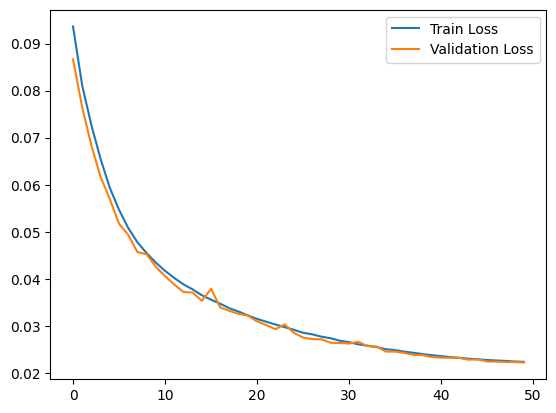

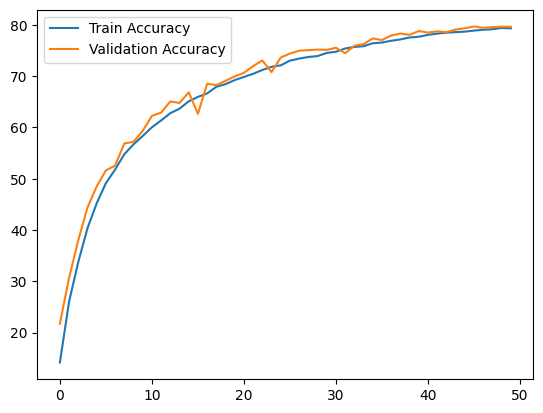

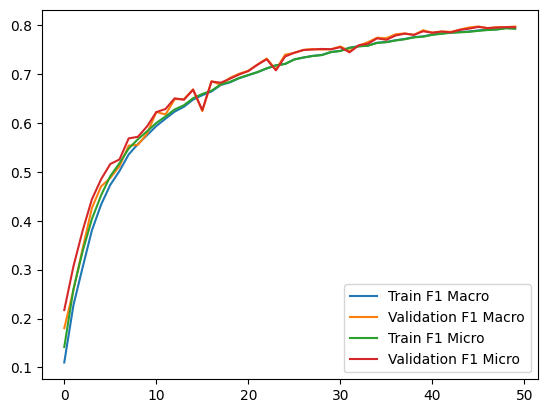

In [5]:
def training():
    transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    train_dataset = torchvision.datasets.ImageFolder(root='/kaggle/input/indian-birds-25/Birds_25/train', transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

    val_dataset = torchvision.datasets.ImageFolder(root='/kaggle/input/indian-birds-25/Birds_25/val', transform=transform)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    
    print("Train Data: ", len(train_dataset))
    print("Validation Data: ", len(val_dataset))

    net = final_resnet(3, r, n, norm_type)

    net = net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.0001)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0.00001)

    train_loss = []
    val_loss = []
    train_accuracy = []
    val_accuracy = []
    train_f1_macro = []
    val_f1_macro = []
    train_f1_micro = []
    val_f1_micro = []

    print("------------------------Training Started------------------------")
    for epoch in range(num_epochs):
        net.train()
        running_loss = 0.0
        correct = 0
        total = 0
        y_true = []
        y_pred = []
        for i, data in enumerate(tqdm(train_loader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
        scheduler.step()
        train_loss.append(running_loss/total)
        train_accuracy.append((correct/total)*100)
        train_f1_macro.append(f1_score(y_true, y_pred, average='macro'))
        train_f1_micro.append(f1_score(y_true, y_pred, average='micro'))

        net.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        y_true = []
        y_pred = []
        with torch.no_grad():
            for i, data in enumerate(tqdm(val_loader)):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())

        val_loss.append(running_loss/total)
        val_accuracy.append((correct/total)*100)
        val_f1_macro.append(f1_score(y_true, y_pred, average='macro'))
        val_f1_micro.append(f1_score(y_true, y_pred, average='micro'))

        print("Epoch: ", epoch, "Train Loss: ", train_loss[-1], "Train Accuracy: ", train_accuracy[-1], "Train F1 Macro: ", train_f1_macro[-1], "Train F1 Micro: ", train_f1_micro[-1])

        print("Epoch: ", epoch, "Validation Loss: ", val_loss[-1], "Validation Accuracy: ", val_accuracy[-1], "Validation F1 Macro: ", val_f1_macro[-1], "Validation F1 Micro: ", val_f1_micro[-1])

        print("---------------------------------------------------------------")

        with open('Part2-custom_instancenorm', 'a') as f:
            f.write("Epoch: " + str(epoch) + " Train Loss: " + str(train_loss[-1]) + " Train Accuracy: " + str(train_accuracy[-1]) + " Train F1 Macro: " + str(train_f1_macro[-1]) + " Train F1 Micro: " + str(train_f1_micro[-1]) + "\n")
            f.write("Epoch: " + str(epoch) + " Validation Loss: " + str(val_loss[-1]) + " Validation Accuracy: " + str(val_accuracy[-1]) + " Validation F1 Macro: " + str(val_f1_macro[-1]) + " Validation F1 Micro: " + str(val_f1_micro[-1]) + "\n")
            f.write("---------------------------------------------------------------\n")

    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.show()

    plt.plot(train_accuracy, label='Train Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.legend()
    plt.show()

    plt.plot(train_f1_macro, label='Train F1 Macro')
    plt.plot(val_f1_macro, label='Validation F1 Macro')
    plt.legend()

    plt.plot(train_f1_micro, label='Train F1 Micro')
    plt.plot(val_f1_micro, label='Validation F1 Micro')
    plt.legend()
    plt.show()

    torch.save(net.state_dict(), 'Part2-custom_instancenorm.pth')
    
    
training()

    
        